# Overview

This example shows how to extract a time series of images from Earth Engine, annotate them, and save them as a video.

# Initialize Earth Engine

We start by importing the [Earth Engine Python API](https://pypi.org/project/earthengine-api/) module.

In [1]:
import ee

The following command initializes the Earth Engine Python API.

In [2]:
ee.Initialize()

If the cell produces output that displays an error about needing to authenticate, open up the notebook entitled `01 - Setup auth credentials` and follow the instructions.

# Building an image collection

In [3]:
import datetime
import ipywidgets as widgets
import ipyleaflet  # an interactive mapping "widget"
from sidecar import Sidecar

## Define User Interface Elements

In [4]:
roi_dimension = widgets.IntSlider(
    value=1e4,
    min=1e2,
    max=1e5,
    description='ROI Size (m):',
    continuous_update=False,
)

In [5]:
# Define the map.
map1 = ipyleaflet.Map(
    center=(0, -80.0),
    zoom=8,
    layout={'height':'300px'},
)
map1.add_control(ipyleaflet.LayersControl())

# Define and add a Marker pin to the map.
center_marker = ipyleaflet.Marker(
    name='ROI Selection Marker',
    location=map1.center
)
map1 += center_marker

roi_layer_group = ipyleaflet.LayerGroup(layers=())
map1 += roi_layer_group

In [6]:
start_datepicker = widgets.DatePicker(
    description='Start Date',
    disabled=False,
    value=datetime.datetime(2017, 8, 20)
)
end_datepicker = widgets.DatePicker(
    description='End Date',
    disabled=False,
    value=datetime.datetime(2017, 9, 20)
)

In [7]:
out = widgets.Output()

## Display the UI Elements

In [8]:
# Layout the UI elements.
panel = widgets.VBox([
    map1,
    start_datepicker,
    end_datepicker,
    roi_dimension,
    out
])

# Display the UI elements in a side panel.
sc = Sidecar(title='UI Panel')
with sc:
    display(panel)

## Define interactions

In [9]:
# Define helper functions to swap the coordinate ordering.
def swap_coordinate_xy_for_location(coord):
    return (coord[1],coord[0]) 
def swap_coordinate_xy_for_list(coord_list):
    return [swap_coordinate_xy_for_location(coord) for coord in coord_list]

def get_roi_polygon():
    center_marker_xy = swap_coordinate_xy_for_location(center_marker.location)
    centroid = ee.Geometry.Point(center_marker_xy)
    buffered = centroid.buffer(roi_dimension.value).bounds()
    return buffered.getInfo()   

def update_roi_layer(map_reference):    
    coord_list_xy = get_roi_polygon()['coordinates'][0]
    coord_list_yx = swap_coordinate_xy_for_list(coord_list_xy)
    
    roi_layer = ipyleaflet.Polygon(
        name='TEST update ROI Polygon',
        locations=coord_list_yx,
        weight=3,
        color='#F00',
        opacity=0.8,
        fill_opacity=0.1,
        fill_color='#F00'
    )
    roi_layer_group.clear_layers()
    roi_layer_group.add_layer(roi_layer)

In [10]:
# Define the actions performed when the marker moves.
def center_marker_on_move(change):
    with out:
        update_roi_layer(map1)
center_marker.unobserve_all()
center_marker.observe(center_marker_on_move, names='location')

In [11]:
# Define the actions performed when the ROI size is changed.
def roi_dimension_on_change(change):
    with out:
        update_roi_layer(map1)
roi_dimension.unobserve_all()
roi_dimension.observe(roi_dimension_on_change, names='value')

# Testing out a series

This section will demonstrate outputing an image time series for a hardcode location, time interval, and image collection.

In [17]:
roi = get_roi_polygon()
roi

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[-47.3886837863829, 81.43089065667475],
   [-44.414220531663226, 81.43089065667475],
   [-44.414220531663226, 81.86523853600423],
   [-47.3886837863829, 81.86523853600423],
   [-47.3886837863829, 81.43089065667475]]]}

In [32]:
start_date = ee.Date(start_datepicker.value.isoformat())
end_date = ee.Date(end_datepicker.value.isoformat())
collection = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
#       .filter(ee.Filter.eq('relativeOrbitNumber_start', 90.0))
#       .filter(ee.Filter.eq('sliceNumber', 16.0))
      .filterDate(start_date, end_date)
      .filterBounds(roi)
      .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
      .select('HV')
)
print(collection.size().getInfo())

26


In [33]:
MAX_ELEMENTS=100
images = collection.toList(MAX_ELEMENTS).getInfo()

In [34]:
[img['id'] for img in images]

['COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDH_20170828T113513_20170828T113538_018123_01E707_8721',
 'COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170820T115043_20170820T115143_007023_00C5FB_0F45',
 'COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170823T121517_20170823T121617_007067_00C733_0260',
 'COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170825T115854_20170825T115954_007096_00C815_FB5C',
 'COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170827T114232_20170827T114332_007125_00C8EE_37A0',
 'COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170829T112609_20170829T112709_007154_00C9BD_B4CD',
 'COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170820T101222_20170820T101250_007022_00C5F2_580C',
 'COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170820T182226_20170820T182330_007027_00C614_7A70',
 'COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170821T105319_20170821T105403_007037_00C65A_195A',
 'COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170822T180609_20170822T180713_007056_00C6DC_4DE0',
 'COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170823T103657_20170823T103737_007066_00C72A_1772',
 'COPERNIC

In [35]:
import os
output_directory = 'output'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDH_20170828T113513_20170828T113538_018123_01E707_8721


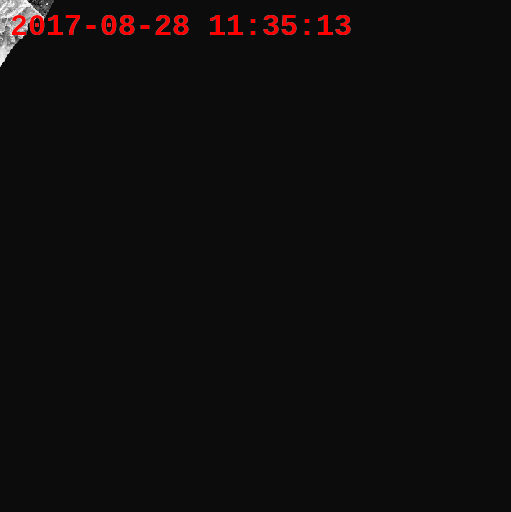

COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170820T115043_20170820T115143_007023_00C5FB_0F45


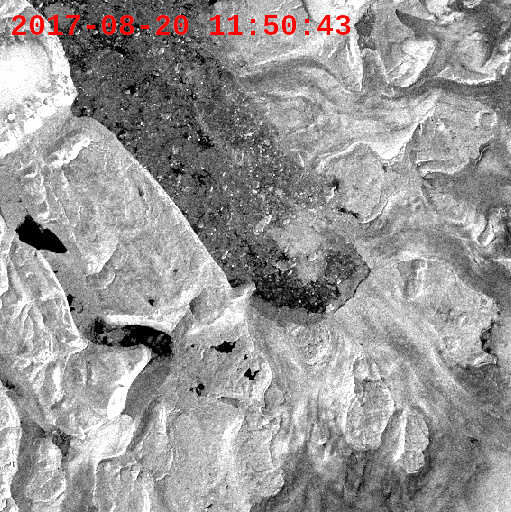

COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170823T121517_20170823T121617_007067_00C733_0260


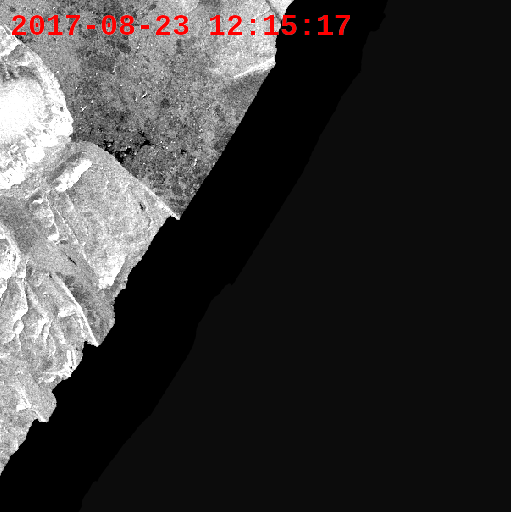

COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170825T115854_20170825T115954_007096_00C815_FB5C


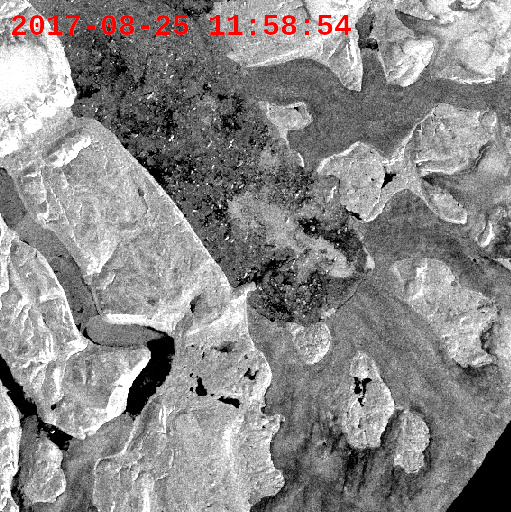

COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170827T114232_20170827T114332_007125_00C8EE_37A0


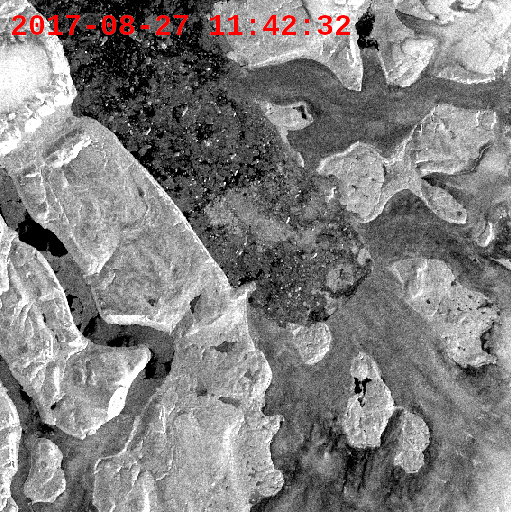

COPERNICUS/S1_GRD/S1B_EW_GRDH_1SDH_20170829T112609_20170829T112709_007154_00C9BD_B4CD


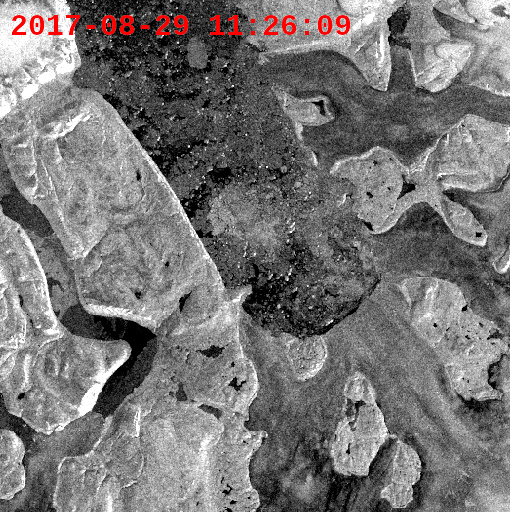

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170820T101222_20170820T101250_007022_00C5F2_580C


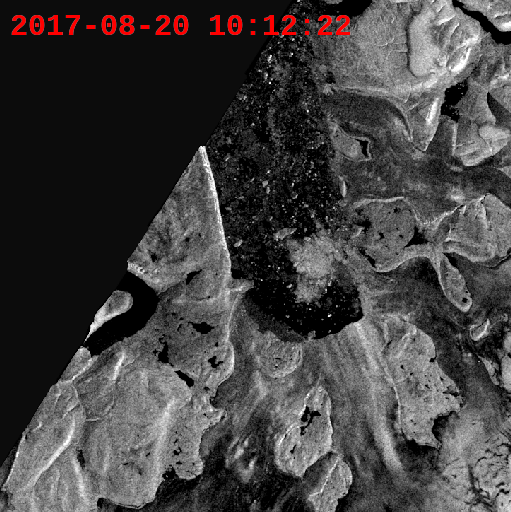

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170820T182226_20170820T182330_007027_00C614_7A70


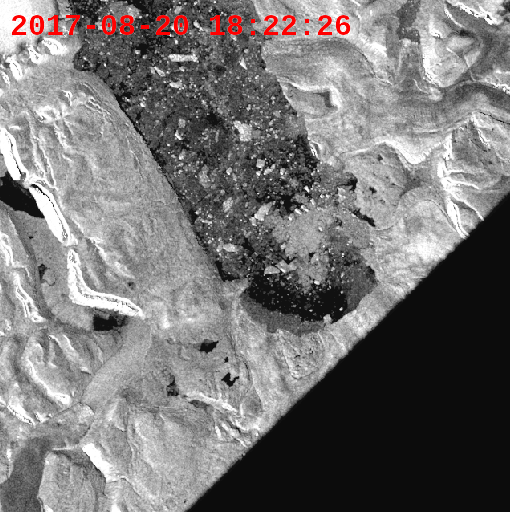

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170821T105319_20170821T105403_007037_00C65A_195A


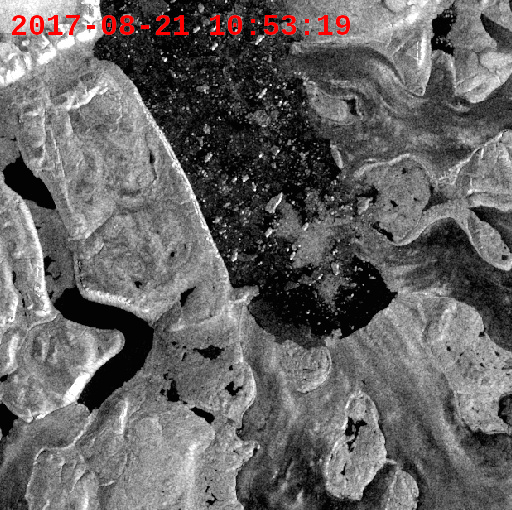

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170822T180609_20170822T180713_007056_00C6DC_4DE0


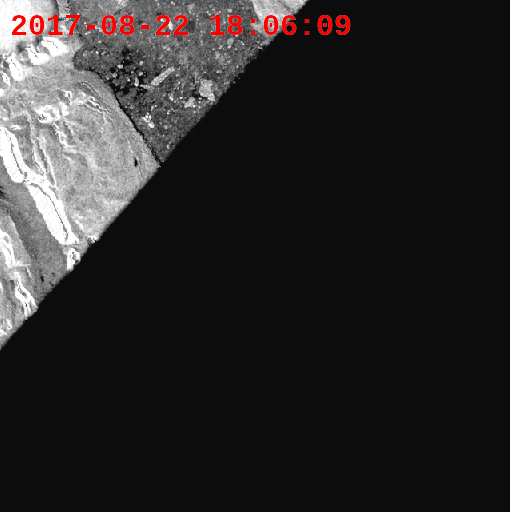

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170823T103657_20170823T103737_007066_00C72A_1772


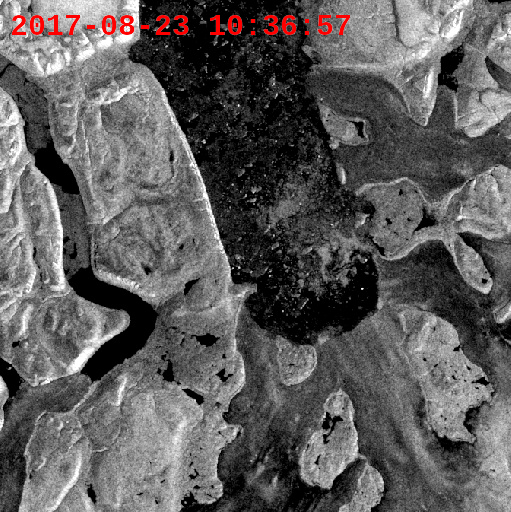

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170823T184703_20170823T184807_007071_00C74C_022A


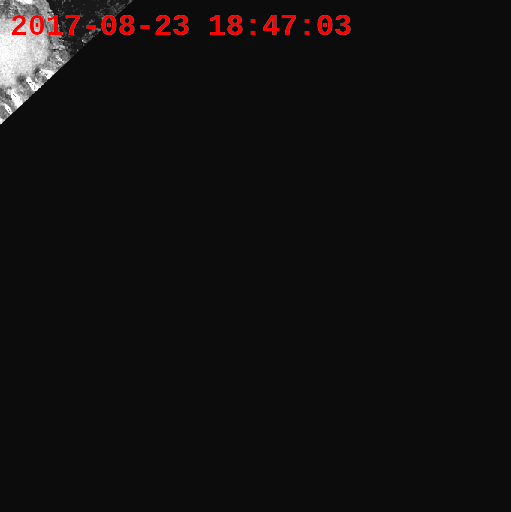

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170824T111754_20170824T111843_007081_00C79E_CA15


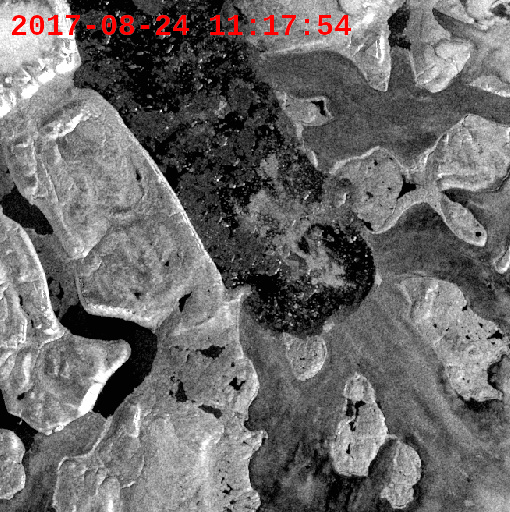

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170824T174946_20170824T175050_007085_00C7BC_C3D7


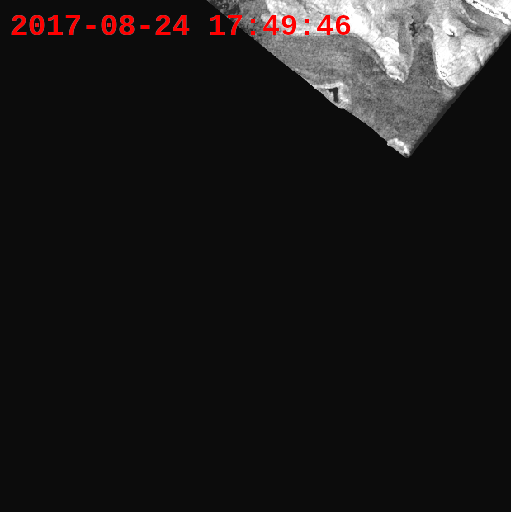

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170826T110131_20170826T110214_007110_00C87F_81FB


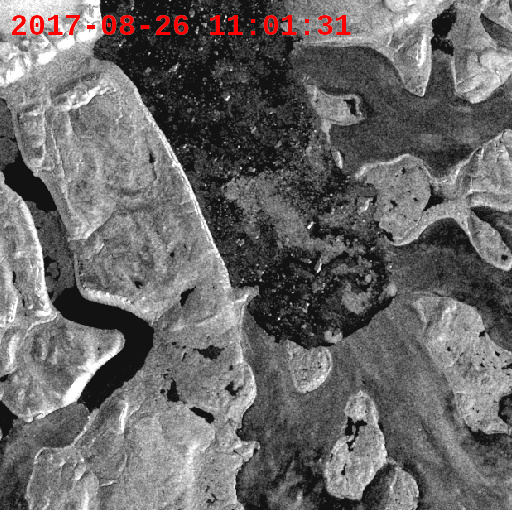

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170827T100420_20170827T100520_007124_00C8E4_CF0E


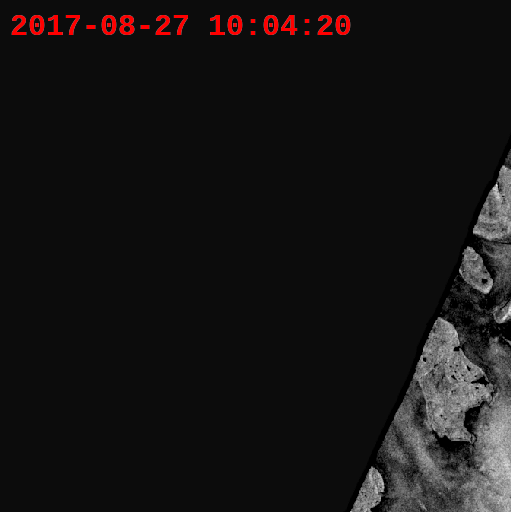

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170827T181421_20170827T181525_007129_00C908_5DAF


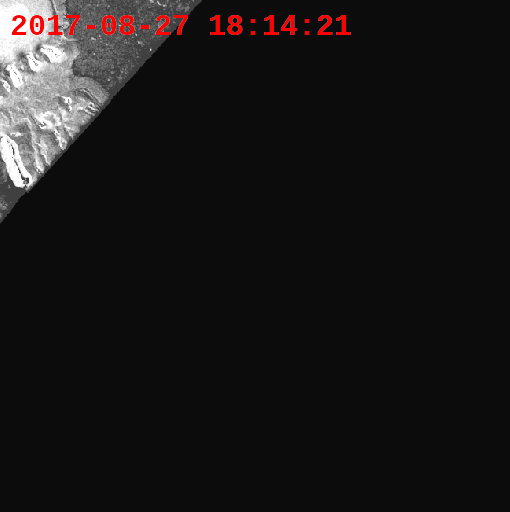

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170828T104514_20170828T104614_007139_00C94D_DBFD


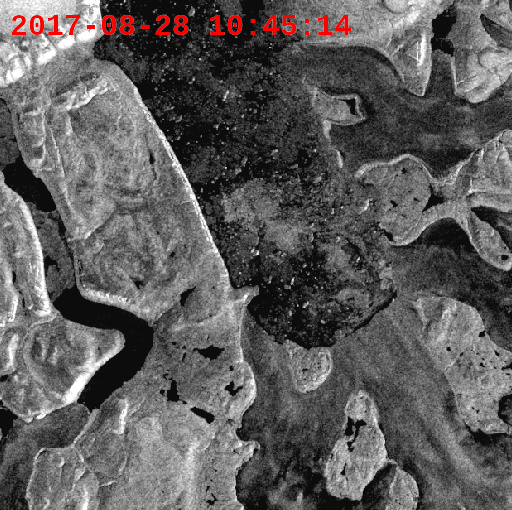

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170828T122329_20170828T122429_007140_00C952_6B35


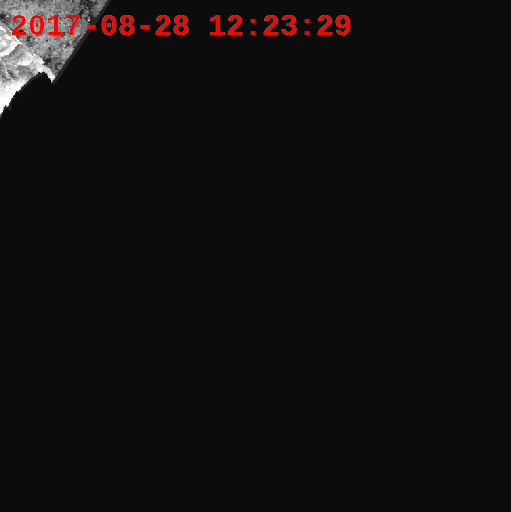

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170828T185515_20170828T185619_007144_00C972_CCAD


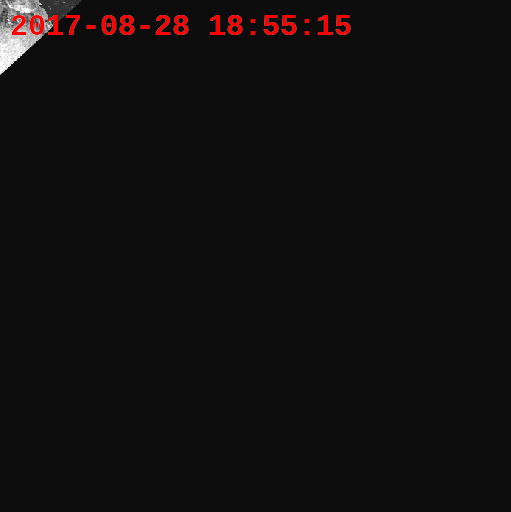

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170829T175758_20170829T175902_007158_00C9D4_3674


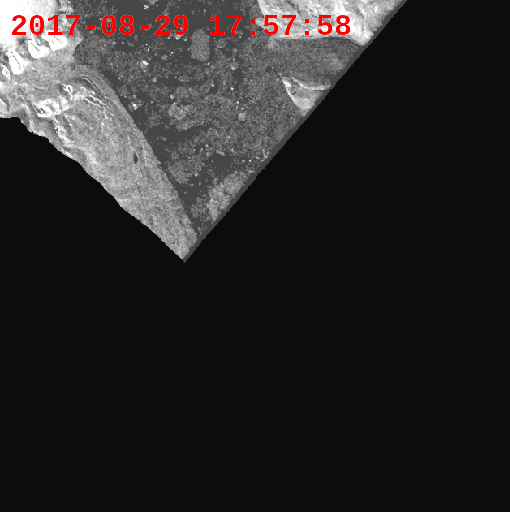

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170830T102846_20170830T102920_007168_00CA23_A269


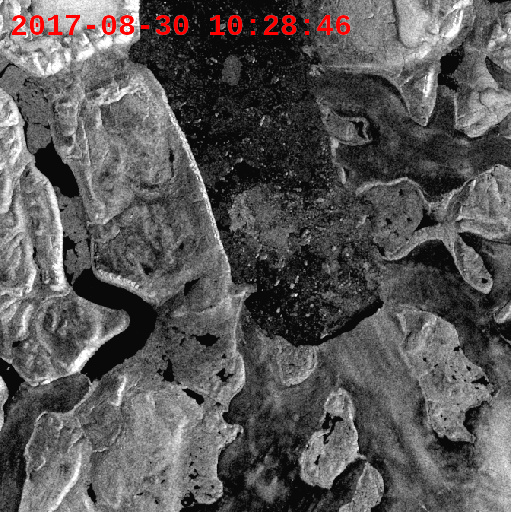

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170830T120706_20170830T120806_007169_00CA2B_108E


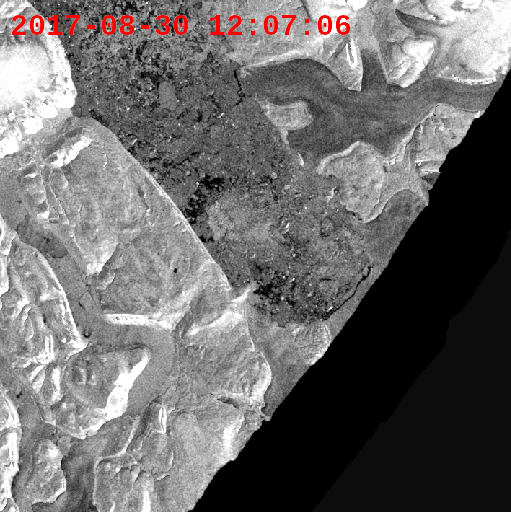

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170830T183852_20170830T183956_007173_00CA4A_2A37


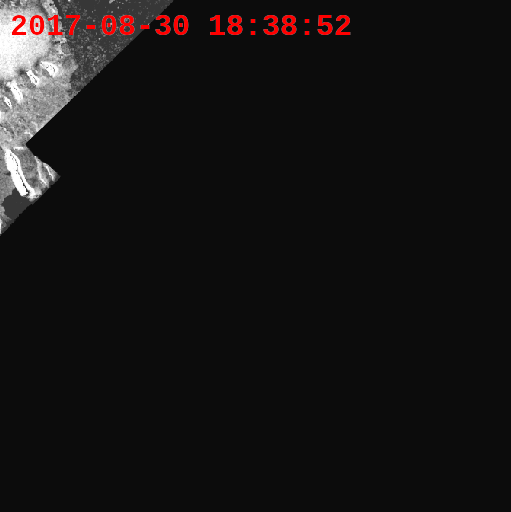

COPERNICUS/S1_GRD/S1B_EW_GRDM_1SDH_20170831T110943_20170831T111026_007183_00CA95_D350


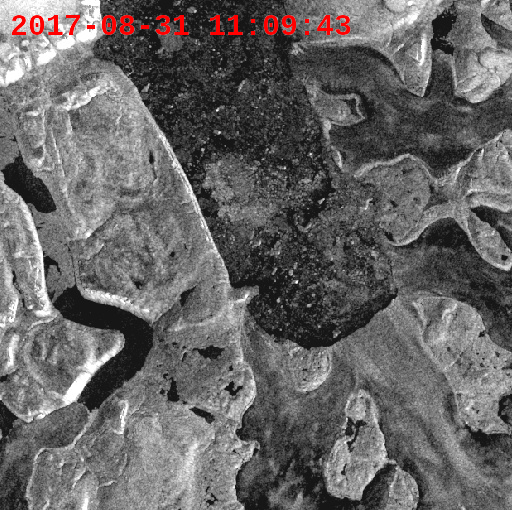

COPERNICUS/S1_GRD/S1B_IW_GRDH_1SDH_20170822T113431_20170822T113456_007052_00C6C5_CA44


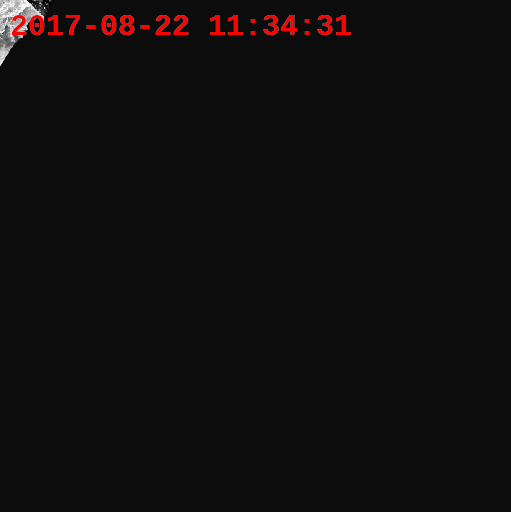

In [38]:
import datetime
from IPython.display import Image
import imageio
import pprint
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont
import requests
import numpy

pp = pprint.PrettyPrinter(indent=4)

sc = Sidecar(title='Images!')
# with sc:
image_no = 0

for img in images:
    image_no += 1
    id = img['id']
    print(id)

    image_time_ms = img['properties']['system:time_start']
    start_time = datetime.datetime.fromtimestamp(image_time_ms/1000.0)

    sample = ee.Image(id)
    url = sample.getThumbUrl({
        'bands': 'HH',
        'min':-20,
        'max':0,
        'region':roi
    })


    # Create a base image, from the Earth Engine Thumbnail URL.
    base_ee = PIL.Image.open(requests.get(url, stream=True).raw).convert('RGBA')

    # Create a background image.
    background = PIL.Image.new('RGBA', base_ee.size, (12,12,12,255))

    # Burn the EE data onto the backgound.
    base = PIL.Image.alpha_composite(background, base_ee)

    # make a blank image for the text, initialized to transparent text color
    txt = PIL.Image.new('RGBA', base_ee.size, (255,255,255,0))

    # Get a font.
    # Additional fonts available on this server can be found by running the following in a terminal:
    # find / -name *.ttf
    fnt = PIL.ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', 30)

    # Get a drawing context.
    d = PIL.ImageDraw.Draw(txt)
    # Draw text. For date formatting codes see:
    # https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    date_string = '{:%Y-%m-%d %H:%M:%S}'.format(start_time)
    d.text((10,10), date_string, font=fnt, fill=(255,0,0,255))
    # Composite the image and text annotation.
    out_image = PIL.Image.alpha_composite(base, txt)

    outfile = '{0}/img{1:03d}.png'.format(output_directory, image_no)
    out_image.save(outfile, format='PNG')

    display(out_image)

## Create an animated GIF.

In [39]:
import glob

gif_images = []
filenames = sorted(glob.glob('output/img???.png'))
for filename in filenames:
    gif_images.append(imageio.imread(filename))
imageio.mimsave('output/movie.gif', gif_images, 'GIF', duration=0.5)

## Create an MPEG video.

In [20]:
%%bash  
ffmpeg -r 1 \
    -i output/img%03d.png \
    -vcodec mpeg4 \
    -y output/out.mp4

ffmpeg version 3.4.2-2 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu2)
  configuration: --prefix=/usr --extra-version=2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzmq --enable-libzvbi --

# Experiment with BQPlot date range selection

In [ ]:
import bqplot
import pandas as pd
import numpy as np

In [ ]:
symbol = 'Security 1'

price_data = pd.DataFrame(
    np.cumsum(np.random.randn(150, 2).dot([[0.5, 0.4], [0.4, 1.0]]), axis=0) + 100,
    columns=['Security 1', 'Security 2'],
    index=pd.date_range(start='01-01-2007', periods=150))

dates_actual = price_data.index.values
prices = price_data[symbol].values

In [ ]:
## First we define a Figure
dt_x_fast = bqplot.DateScale()
lin_y = bqplot.LinearScale()

x_ax = bqplot.Axis(
    label='Index', scale=dt_x_fast)
x_ay = bqplot.Axis(label=(symbol + ' Price'), scale=lin_y, orientation='vertical')
lc = bqplot.Lines(x=dates_actual, y=prices, scales={'x': dt_x_fast, 'y': lin_y}, colors=['orange'])


In [ ]:
## Next we define the type of selector we would like
intsel_fast = bqplot.interacts.FastIntervalSelector(scale=dt_x_fast, marks=[lc, ])

In [ ]:
## We use the HTML widget to see the value of what we are selecting and modify it when an interaction is performed
## on the selector
db_fast = ipywidgets.HTML()
db_fast.value = 'The selected period is ' + str(intsel_fast.selected)

fig_fast_intsel = bqplot.Figure(
    marks=[lc, ],
    axes=[x_ax, x_ay],
    title='Fast Interval Selector Example',
    interaction=intsel_fast #This is where we assign the interaction to this particular Figure
)

ipywidgets.VBox([db_fast, fig_fast_intsel])